# Install Packages

In [1]:
# Install pgmpy
# %pip install pgmpy
# Install daft
# %pip install -U daft
# # Install libgraphviz
# !sudo apt install libgraphviz-dev
# # Install pygraphviz
# %pip install pygraphviz

# Import Libraries

In [41]:
import seaborn
import numpy as np
import pandas as pd
import networkx as nx
import pygraphviz as pgv
import matplotlib.pyplot as plt
from datetime import datetime
import tqdm as notebook_tqdm
from IPython.display import Image
from pgmpy.models import BayesianModel
from pgmpy.sampling import GibbsSampling
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import K2Score, BicScore
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import MaximumLikelihoodEstimator

# Baseline Bayesian Model
---
- Number of students:
>>>- between 18 and 45 : 0
>>>- greater than 45 : 1
- Class Type : 
>>>- Tutorial : 0
>>>- Lab : 1
>>>- Lecture : 2
- Venue size:
>>>- 45 seats : 0
>>>- greater than 45 : 1
- Venue Type:
>>>- Tutorial : 0
>>>- Lab : 1
>>>- Lecture : 2

- Venue:
>>>- No : 0
>>>- Yes : 1


In [18]:
# define model structure
digraph = (("Num_students", "Class"),
        ("Class_Type", "Class"),
        ("Class","Distance"),
        ("Venue_Size", "Venues"),
        ("Venue_Type", "Venues"),
        ("Venues", "Distance"),
        ("Distance", "Venue"))
baseline_model = BayesianNetwork(digraph)

## Define Conditional Probabilities

### Random Conditional Probability Values
- computes random cpd values for each variable that add up to 1

In [19]:
def cpd_values(variable_card, evidence_card = [1]):
  n = np.prod(evidence_card)
  M = np.random.rand(variable_card, n)
  r = M.sum(axis=0)
  values = np.around(M / r, 3)
  return values.tolist()

### Root Nodes

#### Class Type

In [20]:
cpd_class_type = TabularCPD(variable="Class_Type", variable_card=3, values=cpd_values(variable_card=3))
# values=[[0.6], [0.2], [0.2]]
baseline_model.add_cpds(cpd_class_type)
print(cpd_class_type)

+---------------+-------+
| Class_Type(0) | 0.036 |
+---------------+-------+
| Class_Type(1) | 0.405 |
+---------------+-------+
| Class_Type(2) | 0.558 |
+---------------+-------+


#### Number of Students

In [21]:
cpd_num_students = TabularCPD(variable="Num_students", variable_card=2, values=cpd_values(variable_card=2))
# values=[[0.2], [0.8]]
baseline_model.add_cpds(cpd_num_students)
print(cpd_num_students)

+-----------------+-------+
| Num_students(0) | 0.214 |
+-----------------+-------+
| Num_students(1) | 0.786 |
+-----------------+-------+


#### Venue Type

In [22]:
cpd_venue_type = TabularCPD( variable="Venue_Type", variable_card=3, values=cpd_values(variable_card=3))
# values=[[0.65], [0.20], [0.15]]
baseline_model.add_cpds(cpd_venue_type)
print(cpd_venue_type)

+---------------+-------+
| Venue_Type(0) | 0.189 |
+---------------+-------+
| Venue_Type(1) | 0.142 |
+---------------+-------+
| Venue_Type(2) | 0.669 |
+---------------+-------+


#### Venue Size

In [23]:
cpd_venue_size = TabularCPD( variable="Venue_Size", variable_card=2, values=cpd_values(variable_card=2))
# values=[[0.2], [0.8]]
baseline_model.add_cpds(cpd_venue_size)
print(cpd_venue_size)

+---------------+-------+
| Venue_Size(0) | 0.876 |
+---------------+-------+
| Venue_Size(1) | 0.124 |
+---------------+-------+


### Internal Nodes

#### Class

In [24]:
cpd_class = TabularCPD( variable="Class",
                       variable_card=3,
                       values=cpd_values(variable_card=3, evidence_card=[2, 3]),
                       evidence=["Num_students", "Class_Type"],
                       evidence_card=[2, 3])
# values=[[0.03, 0.05, 0.92, 0.72, 0.39, 0.08], [0.79, 0.55, 0.02, 0.03, 0.01, 0.77], [0.18, 0.4, 0.06, 0.25, 0.6, 0.15]], 
baseline_model.add_cpds(cpd_class)
print(cpd_class)

+--------------+-----------------+-----+-----------------+
| Num_students | Num_students(0) | ... | Num_students(1) |
+--------------+-----------------+-----+-----------------+
| Class_Type   | Class_Type(0)   | ... | Class_Type(2)   |
+--------------+-----------------+-----+-----------------+
| Class(0)     | 0.325           | ... | 0.225           |
+--------------+-----------------+-----+-----------------+
| Class(1)     | 0.351           | ... | 0.072           |
+--------------+-----------------+-----+-----------------+
| Class(2)     | 0.324           | ... | 0.703           |
+--------------+-----------------+-----+-----------------+


#### Venues
- possible vebues to choose from

In [25]:
cpd_venues = TabularCPD( 
    variable="Venues",
    variable_card= 3,
    values=cpd_values(variable_card=3, evidence_card=[3, 2]),
    evidence=["Venue_Type", "Venue_Size"],
    evidence_card=[3, 2],
)
#values=[[0.65, 0.35, 0.23, 0.22, 0.14, 0.32], [0.25, 0.45, 0.32, 0.63, 0.001, 0.18], [0.1, 0.2, 0.45, 0.15, 0.859, 0.5]],
baseline_model.add_cpds(cpd_venues)
print(cpd_venues)

+------------+---------------+-----+---------------+---------------+
| Venue_Type | Venue_Type(0) | ... | Venue_Type(2) | Venue_Type(2) |
+------------+---------------+-----+---------------+---------------+
| Venue_Size | Venue_Size(0) | ... | Venue_Size(0) | Venue_Size(1) |
+------------+---------------+-----+---------------+---------------+
| Venues(0)  | 0.326         | ... | 0.298         | 0.394         |
+------------+---------------+-----+---------------+---------------+
| Venues(1)  | 0.353         | ... | 0.32          | 0.132         |
+------------+---------------+-----+---------------+---------------+
| Venues(2)  | 0.321         | ... | 0.383         | 0.473         |
+------------+---------------+-----+---------------+---------------+


#### Distance

In [26]:
cpd_distance = TabularCPD( variable="Distance", variable_card=3,
                          values=cpd_values(variable_card=3, evidence_card=[3, 3]),
                          evidence=["Class","Venues"],
                          evidence_card=[3, 3])
# values=[[0.03, 0.05, 0.92, 0.72, 0.39, 0.08, 0.03, 0.05, 0.92], [0.79, 0.55, 0.02, 0.03, 0.01, 0.77, 0.79, 0.55, 0.02], [0.18, 0.4, 0.06, 0.25, 0.6, 0.15, 0.18, 0.4, 0.06]], 
baseline_model.add_cpds(cpd_distance)
print(cpd_distance)

+-------------+-----------+-----+-----------+-----------+
| Class       | Class(0)  | ... | Class(2)  | Class(2)  |
+-------------+-----------+-----+-----------+-----------+
| Venues      | Venues(0) | ... | Venues(1) | Venues(2) |
+-------------+-----------+-----+-----------+-----------+
| Distance(0) | 0.039     | ... | 0.582     | 0.531     |
+-------------+-----------+-----+-----------+-----------+
| Distance(1) | 0.496     | ... | 0.056     | 0.395     |
+-------------+-----------+-----+-----------+-----------+
| Distance(2) | 0.465     | ... | 0.362     | 0.074     |
+-------------+-----------+-----+-----------+-----------+


### Terminal Node

#### Venue

In [27]:
cpd_venue = TabularCPD( variable="Venue", variable_card=3,
                       values=cpd_values(variable_card=3, evidence_card=[3]),
                       evidence=["Distance"], 
                       evidence_card=[3])
# values=[[0.03, 0.05, 0.92],  [0.79, 0.55, 0.02], [0.18, 0.4, 0.06]], 
baseline_model.add_cpds(cpd_venue)
print(cpd_venue)

+----------+-------------+-------------+-------------+
| Distance | Distance(0) | Distance(1) | Distance(2) |
+----------+-------------+-------------+-------------+
| Venue(0) | 0.393       | 0.367       | 0.422       |
+----------+-------------+-------------+-------------+
| Venue(1) | 0.246       | 0.34        | 0.418       |
+----------+-------------+-------------+-------------+
| Venue(2) | 0.361       | 0.293       | 0.16        |
+----------+-------------+-------------+-------------+


## Check model
---
Check the model for various errors. This method checks for the following errors.

> - Checks if the sum of the probabilities for each state is equal to 1 (tol=0.01).
> - Checks if the CPDs associated with nodes are consistent with their parents.

Returns: check – True if all the checks are passed

In [28]:
# Check if the model is valid, throw an exception otherwise
baseline_model.check_model()

True

## Visualize all probabilities

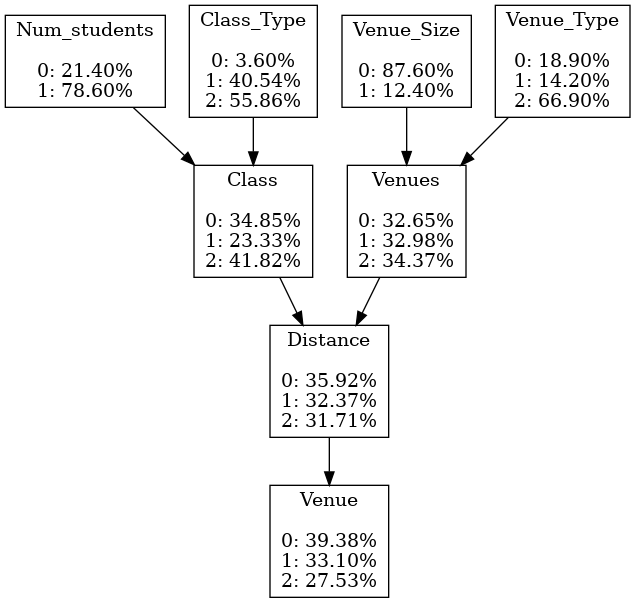

In [29]:
G = pgv.AGraph(directed=True)
inference = VariableElimination(baseline_model)

for element in digraph:

    probability_0 = inference.query([element[0]], show_progress=False)
    probability_1 = inference.query([element[1]], show_progress=False)

    probability_0_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_0.values)]
    )
    probability_1_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_1.values)]
    )

    G.add_node(element[0], label=element[0] + "\n\n" + probability_0_str)
    G.add_node(element[1], label=element[1] + "\n\n" + probability_1_str)

    G.get_node(element[0]).attr["shape"] = "box"
    G.get_node(element[1]).attr["shape"] = "box"

    G.add_edge(element[0], element[1])

Image(G.draw(format="png", prog="dot"))

# Sampling

## Foward Sampling

In [55]:
def foward_sample(model, size=int(1e3)):

	inference = BayesianModelSampling(model)
	data = inference.forward_sample(size)
	data = data.sample(frac=1).reset_index(drop=True)

	return data

data = foward_sample(baseline_model)

Generating for node: Class_Type:   0%|          | 0/8 [00:00<?, ?it/s]  /home/mmasehume/.local/lib/python3.8/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 0.0009999999999998899. Adjusting values.
  warn(
Generating for node: Venue: 100%|██████████| 8/8 [00:00<00:00, 86.60it/s]


## Gibbs Sampling
- each random variable is iteratively resampled from its conditional distribution given the remaining

In [16]:
def gibbs_sample(model, size=int(1e3)):
	inference = GibbsSampling(model)
	data = inference.sample(size).reset_index(drop=True)
	return data

## Store data in csv

In [56]:
data.to_csv('./data/foward_sample '+ '.csv')
#  str(datetime.now())+

# Structure Learning

## Score Based Structure Learning
- this approach construes model selection as an optimization task
- Has two building blocks:
	- 1. A scoring function $s_D\colon M \to \mathbb R$ that maps models to a numerical score, based on how well they fit to a given data set $D$
	- 2. A search strategy to traverse the search space of possible models $M$ and select a model with optimal score.
- Commonly used scores to measure the fit between model and data are :
	- Bayesian Dirichlet scores such as BDeu or K2 
	- Bayesian Information Criterion (BIC, also called MDL)
- 

### Learn the model structure using Hill-Climb Search with K2score

  0%|          | 7/10000 [00:00<10:50, 15.35it/s]


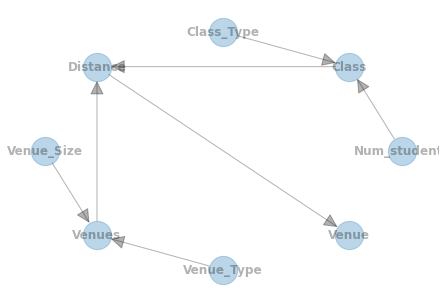

In [57]:
scoring_method = K2Score(data=data)
est = HillClimbSearch(data=data)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4)
)

# print f1 score
# print(get_f1_score(estimated_model, baseline_model))

# print nodes and edges from model generated g
# print(sorted(estimated_model.nodes()))
# print(sorted(estimated_model.edges()))

nx.draw_circular(
    estimated_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

### Learn the model structure using Hill-Climb Search with BIC Score

  0%|          | 6/10000 [00:00<12:02, 13.83it/s]


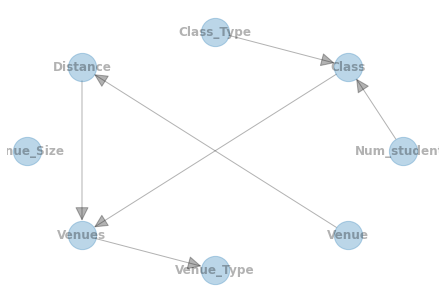

In [58]:
scoring_method1 = BicScore(data=data)
bic_est = HillClimbSearch(data=data)
bic_model = bic_est.estimate(
    scoring_method=scoring_method1, max_indegree=4, max_iter=int(1e4)
)

# get_f1_score(bic_model, venue_model)
nx.draw_circular(
    bic_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

### Learn the model structure using Hill-Climb Search with Bdeu Score

In [ ]:
# scoring_method2 = BdeuScore(data=data)
# bdeu_est = HillClimbSearch(data=data)
# bdeu_model = bdeu_est.estimate(
#     scoring_method=scoring_method2, max_indegree=4, max_iter=int(1e4)
# )

# # get_f1_score(bdeu_model, venue_model)
# nx.draw_circular(
#     bdeu_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
# )
# plt.show()

## Hybrid Structure Learning
The MMHC algorithm combines the constraint-based and score-based method. It has two parts:

- 1.Learn undirected graph skeleton using the constraint-based construction procedure MMPC

- 2.Orient edges using score-based optimization (BDeu score + modified hill-climbing)


Part 1) Skeleton:  [('Num_students', 'Venue_Type'), ('Num_students', 'Distance'), ('Class', 'Class_Type'), ('Class', 'Venue_Size'), ('Class_Type', 'Venue'), ('Class_Type', 'Distance'), ('Class_Type', 'Venues'), ('Distance', 'Venues'), ('Venue_Size', 'Venue')]


  0%|          | 2/1000000 [00:00<15:17:28, 18.17it/s]

Part 2) Model:     [('Class_Type', 'Class'), ('Distance', 'Venues')]


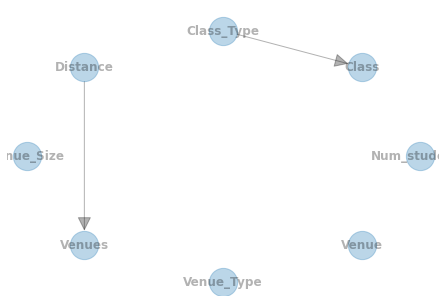

In [61]:
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import BDeuScore

# est = MmhcEstimator(data)
# Mmhc_model = est.estimate()
# print(Mmhc_model.edges())
# nx.draw_circular(
#     Mmhc_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
# )
# plt.show()

mmhc = MmhcEstimator(data)
skeleton = mmhc.mmpc()
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(data)
Mmhc_model = hc.estimate(scoring_method=BDeuScore(data), white_list=skeleton.to_directed().edges())
print("Part 2) Model:    ", Mmhc_model.edges())
nx.draw_circular(
    Mmhc_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

# Parameter Learning

### Maximum Likelihood Estimation
- estimates the conditional probability tables (CPTs) for the variables of a Bayesian Network, given some data set.

#### STEPS
- use the relative frequencies, with which the variable states have occured.
- we should fill the CPDs in such a way, that $P(\text{data}|\text{model})$ is maximal.

#### KEY :
- >  mle.estimate_cpd(variable) computes the state counts and divides each cell by the (conditional) sample size. 
- >  mle.get_parameters() returns a list of CPDs for all variable of the model.

#### Problems with MLE :
- overfits data
- If the observed data is not representative for the underlying distribution, ML estimations will be extremly far off.
- When estimating parameters for Bayesian networks, lack of data is a frequent problem.
- Even if the total sample size is very large, the fact that state counts are done conditionally for each parents configuration causes immense fragmentation
- If a variable has 3 parents that can each take 10 states, then state counts will be done seperately for 10^3 = 1000 parents configurations. 
- This makes MLE very fragile and unstable for learning Bayesian Network parameters. 
- A way to mitigate MLE's overfitting is Bayesian Parameter Estimation.

In [62]:
# Defining the Bayesian Model structure, copy baseline
mle_model =  baseline_model.copy()

# estimates cpds, returns list of cpds
# mle = MaximumLikelihoodEstimator(mle_model, data)
# mle.get_parameters()

# adjust all CPDs of `model` using MLE, estimates cpds inplace
mle_model.fit(data, estimator=MaximumLikelihoodEstimator)
for cpd in mle_model.get_cpds():
	print(cpd)

+---------------+-------+
| Class_Type(0) | 0.032 |
+---------------+-------+
| Class_Type(1) | 0.405 |
+---------------+-------+
| Class_Type(2) | 0.563 |
+---------------+-------+
+-----------------+-------+
| Num_students(0) | 0.185 |
+-----------------+-------+
| Num_students(1) | 0.815 |
+-----------------+-------+
+---------------+-------+
| Venue_Type(0) | 0.182 |
+---------------+-------+
| Venue_Type(1) | 0.142 |
+---------------+-------+
| Venue_Type(2) | 0.676 |
+---------------+-------+
+---------------+-------+
| Venue_Size(0) | 0.878 |
+---------------+-------+
| Venue_Size(1) | 0.122 |
+---------------+-------+
+--------------+-----------------+-----+---------------------+
| Class_Type   | Class_Type(0)   | ... | Class_Type(2)       |
+--------------+-----------------+-----+---------------------+
| Num_students | Num_students(0) | ... | Num_students(1)     |
+--------------+-----------------+-----+---------------------+
| Class(0)     | 0.25            | ... | 0.23965141

### Bayesian Parameter Estimation
- starts with already existing prior CPDs, that express our beliefs about the variables before the data was observed.
- Those "priors" are then updated, using the state counts from the observed data
- One can think of the priors as consisting in pseudo state counts, that are added to the actual counts before normalization. 
- Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, i.e. ones that deem all states equiprobable

#### Priors
- K2 prior - simply adds 1 to the count of every single state.
- BDeu (Bayesian Dirichlet equivalent uniform) prior - is a somewhat more sensible choice of prior. 
	- For BDeu we need to specify an equivalent sample size N and then the pseudo-counts are the equivalent of having observed N uniform samples of each variable (and each parent configuration)

##### K2 prior

In [63]:
# Defining the Bayesian Model structure, copy baseline
bpe_model =  baseline_model.copy()

# estimates cpds, returns list of cpds
# bpe = BayesianEstimator(mle_model, data)
# bpe.get_parameters()

# adjust all CPDs of `model` using MLE, estimates cpds inplace
bpe_model.fit(data, estimator=BayesianEstimator, prior_type="k2")
for cpd in bpe_model.get_cpds():
	print(cpd)

+---------------+-----------+
| Class_Type(0) | 0.0329013 |
+---------------+-----------+
| Class_Type(1) | 0.404786  |
+---------------+-----------+
| Class_Type(2) | 0.562313  |
+---------------+-----------+
+-----------------+----------+
| Num_students(0) | 0.185629 |
+-----------------+----------+
| Num_students(1) | 0.814371 |
+-----------------+----------+
+---------------+----------+
| Venue_Type(0) | 0.182453 |
+---------------+----------+
| Venue_Type(1) | 0.142572 |
+---------------+----------+
| Venue_Type(2) | 0.674975 |
+---------------+----------+
+---------------+----------+
| Venue_Size(0) | 0.877246 |
+---------------+----------+
| Venue_Size(1) | 0.122754 |
+---------------+----------+
+--------------+-----+---------------------+
| Class_Type   | ... | Class_Type(2)       |
+--------------+-----+---------------------+
| Num_students | ... | Num_students(1)     |
+--------------+-----+---------------------+
| Class(0)     | ... | 0.24025974025974026 |
+--------------+-

##### BDeu prior

In [64]:
# Defining the Bayesian Model structure, copy baseline
bpe_model =  baseline_model.copy()

# estimates cpds, returns list of cpds
# bpe = BayesianEstimator(mle_model, data)
# bpe.get_parameters()

# adjust all CPDs of `model` using MLE, estimates cpds inplace
bpe_model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")
for cpd in bpe_model.get_cpds():
	print(cpd)

+---------------+-----------+
| Class_Type(0) | 0.0334992 |
+---------------+-----------+
| Class_Type(1) | 0.404643  |
+---------------+-----------+
| Class_Type(2) | 0.561857  |
+---------------+-----------+
+-----------------+----------+
| Num_students(0) | 0.186567 |
+-----------------+----------+
| Num_students(1) | 0.813433 |
+-----------------+----------+
+---------------+----------+
| Venue_Type(0) | 0.182753 |
+---------------+----------+
| Venue_Type(1) | 0.142952 |
+---------------+----------+
| Venue_Type(2) | 0.674295 |
+---------------+----------+
+---------------+----------+
| Venue_Size(0) | 0.876119 |
+---------------+----------+
| Venue_Size(1) | 0.123881 |
+---------------+----------+
+--------------+-----+---------------------+
| Class_Type   | ... | Class_Type(2)       |
+--------------+-----+---------------------+
| Num_students | ... | Num_students(1)     |
+--------------+-----+---------------------+
| Class(0)     | ... | 0.23982119125286938 |
+--------------+-

# Evaluation

### Correlation Score
- Function to score how well the model structure represents the correlations in the data.
- The model doesn’t need to be parameterized for this scor

In [67]:
from pgmpy.metrics import correlation_score
# baseline score
print('*'*5, "CORRELATION SCORES", '*'*5)
print()
print('*'*5, "Baseline model", '*'*5)
print(correlation_score(baseline_model, data, test="chi_square", significance_level=0.05), "\n")

print('*'*5, "Hill Climb Correllation scores", '*'*5)
print('-'*5, "K2 score model", '-'*5)
print(correlation_score(estimated_model, data, test="chi_square", significance_level=0.05))
print('-'*5, "Bic score model",'-'*5)
print(correlation_score(bic_model, data, test="chi_square", significance_level=0.05), "\n")
print('*'*5, "Hybrid Structure Learning scores", '*'*5)
print('-'*5, "Mmhc_model score model",'-'*5)
print(correlation_score(Mmhc_model, data, test="chi_square", significance_level=0.05))


***** CORRELATION SCORES *****

***** Baseline model *****
0.6206896551724137 

***** Hill Climb Correllation scores *****
----- K2 score model -----
0.6206896551724137
----- Bic score model -----
0.75 

***** Hybrid Structure Learning scores *****
----- Mmhc_model score model -----
0.8181818181818181


### log-likelihood score
- Computes the log-likelihood of a given dataset i.e. $P(data | model)$.
- can be used to check how well the specified model describes the data. 
- This method requires the parameters of the model to be specified as well. 
- Direct interpretation of this score is difficult but can be used to compare the fit of two or more models. 
- A higher score means ab better fit

In [70]:
from pgmpy.metrics import log_likelihood_score
print('*'*5, "LOG-LIKELIHOOD SCORE", '*'*5)
print()
print('*'*5, "Baseline model", '*'*5)
print(log_likelihood_score(baseline_model, data), "\n")

print('*'*5, "Hill Climb Search scores", '*'*5)
print('-'*5, "K2 score model", '-'*5)
print(log_likelihood_score(estimated_model, data))
print('-'*5, "Bic score model",'-'*5)
print(log_likelihood_score(bic_model, data), "\n")
print('*'*5, "Hybrid Structure Learning scores", '*'*5)
print('-'*5, "Mmhc_model score model",'-'*5)
print(log_likelihood_score(Mmhc_model, data))

***** LOG-LIKELIHOOD SCORE *****

***** Baseline model *****
-6480.400633449785 

***** Hill Climb Search scores *****
----- K2 score model -----


ValueError: Only Bayesian Networks are supported. Got <class 'pgmpy.base.DAG.DAG'>.